In [31]:
import sys
from pathlib import Path

path_root = Path( '/project_ghent/HADSP/reservoirpy/')
sys.path.append(str(path_root))
path_root = Path( '/project_ghent/HADSP/hadsp/')
sys.path.append(str(path_root))

In [2]:
import numpy as np
from scipy import sparse

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Utility functions
from reservoir.utility import show_matrice, show_ei_matrix

# Reservoir functions

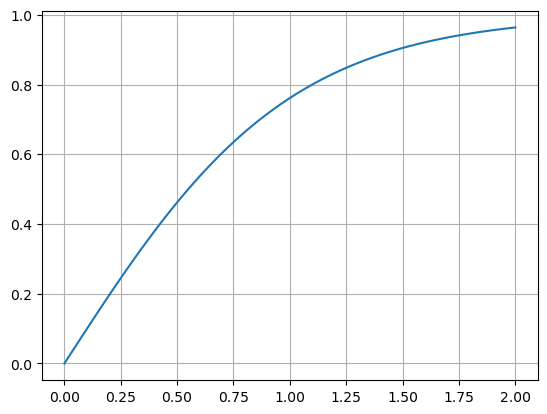

In [3]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_ei_reservoir, update_reservoir, ridge_regression, train, run
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(0, 2, 100), activation_function(np.linspace(0, 2, 100)))
plt.grid()

In [4]:
from scipy.stats import poisson

mu = 100
timesteps = 20000
n_e=100

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs1 = (U - U.min()) / (U.max() - U.min())

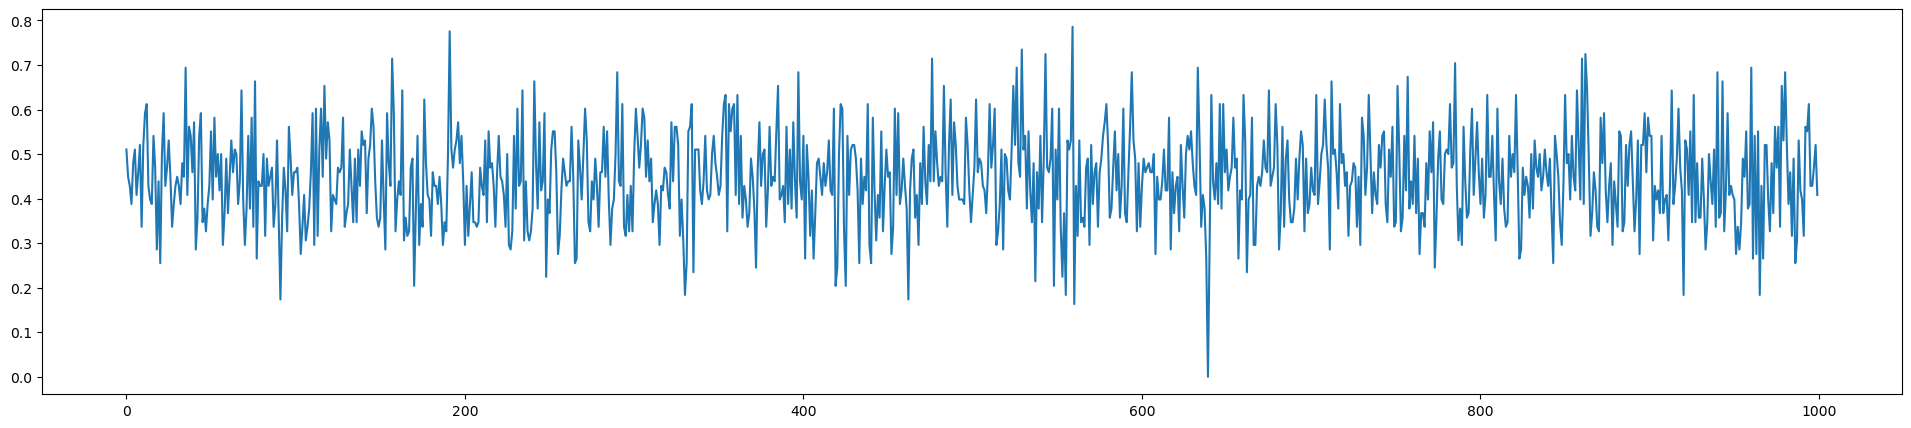

In [5]:
plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs1[4,16000:17000])
plt.show()

In [6]:
from scipy import signal

# Apply a low-pass filter on with scipy.signal.filtfilt
def low_pass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, btype='low', analog=False, fs=fs)
    return signal.filtfilt(b, a, data)

def high_pass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, btype='high', analog=False, fs=fs)
    return signal.filtfilt(b, a, data)

def band_pass_filter(data, lowcut, highcut, fs, order=5):
    b, a = signal.butter(3, [lowcut, highcut], btype='band', fs=fs)
    return signal.filtfilt(b, a, data)


# Algorithm
https://www.nature.com/articles/s41598-018-22077-3#Fig1

$ \Delta z_i =  \frac {1}{\beta}(target\_r - r_i) $

In [7]:
# helper function
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

## Matrice initialization

https://www.nature.com/articles/s41598-018-22077-3
Based initialy on : 

    https://www.nature.com/articles/s41598-018-22077-3/tables/1
    N = 125 (12500 in the paper)
    Ratio of ne% = 0.8 -> ne = 100; ni% = 0.2  -> ni=25
    
    W_ei : Incoming excitatory connections per inhibitory neuron :10, with synaptic weight = 0.1mV
    W_ie : Incoming inhibitory connections per neuron :2,5, with synamtic weight : -0.8mV

In [8]:
from reservoir.reservoir import init_matrices

# Parameters
n_e = 100 # number of neurons for excitatory pool
n_i = 0 # number of neurons for inhibitory pool
SEED = 65718 # previous 3789
leaky_rate = 1

spectral_radius = 1
input_connectivity = 1
connectivity = 0.1 # from the article

# HYPERPARAMETERS
INTERVAL_CONSTANT = 100
VALUE = 0.1
bias_scaling = 1
input_scaling = 0.1


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)


<Axes: >

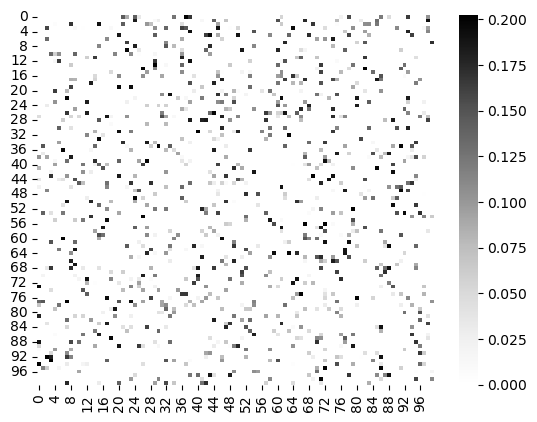

In [9]:
heatmap(W_ee.todense(), cmap=color_palette("Greys", as_cmap=True))

## Parameters grid exploration
From an existing matrice

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  2.0min finished


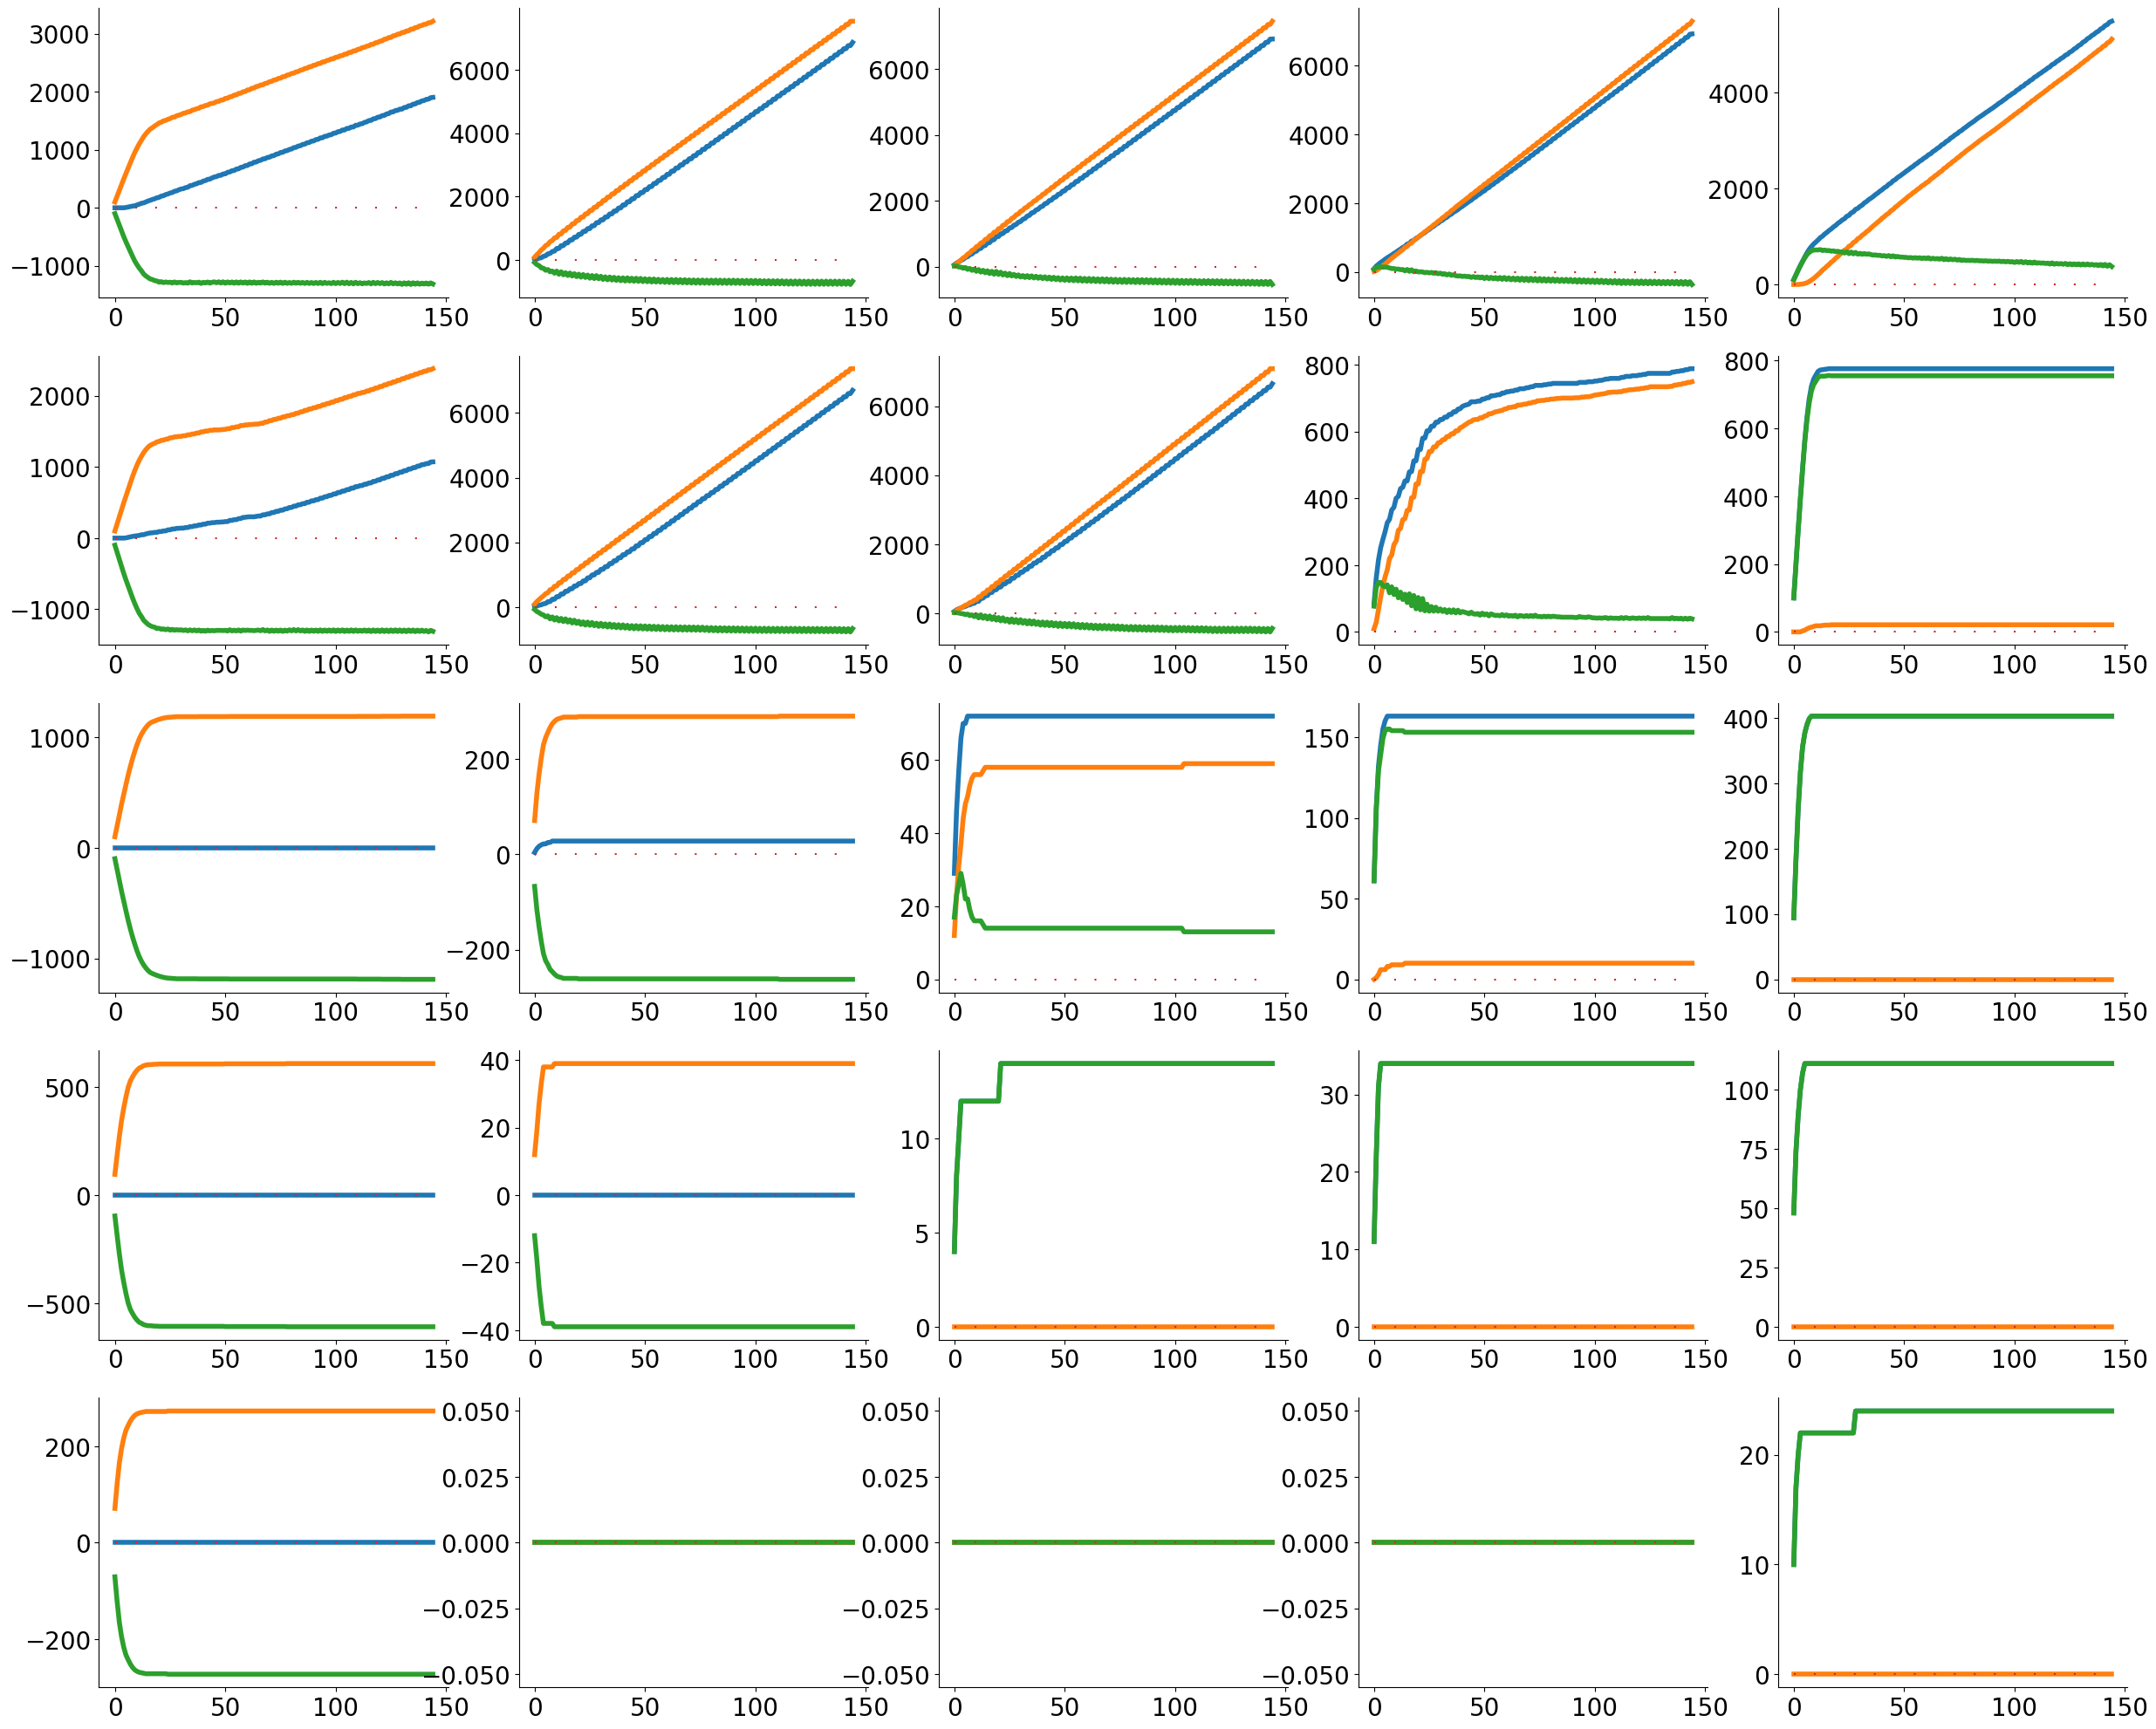

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
from joblib import Parallel, delayed
import numpy as np

# These seem like module reloads in IPython
# reload(connexion_generation.bounded_adsp)
# reload(connexion_generation.utility)

GROWTH_PARAMETER_ARRAY = [0.001, 0.01, 0.1, 0.3, 0.5]
TARGET_RATE_ARRAY = [0.1, 0.5, 0.7, 0.8, 0.95]

# Function to run the simulation for a given set of parameters
def run_simulation(growth_parameter, target_rate):
    # (Place here all the required initializations and constant definitions)
    
    # For instance:
    W_ee_adsp = W_ee.copy()
    u_train_adsp1 = inputs1.copy()
    state_e = last_state_e
    Win_adsp = Win_e
    step = 0
    total_add = 0
    total_prun = 0
    add = []
    prun = []
    state_history_e = []

    for i in range(INTERVAL_CONSTANT * 5):
        state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
        state_history_e.append(state_e)
    u_train_adsp1 = u_train_adsp1[:, INTERVAL_CONSTANT * 5:]
    train_length = len(u_train_adsp1[1, :])

    while train_length > 5000:
        # For excitatory neurons (We and Wie)
        delta_z = compute_synaptic_change(state_history_e[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
        W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z, VALUE)

        # For inhibitory neurons (Wi)
        # delta_z_i = compute_synaptic_change(state_history_i[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
        # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = bounded_adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

        for i in range(INTERVAL_CONSTANT):
            state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
            state_history_e.append(state_e)
        u_train_adsp1 = u_train_adsp1[:, INTERVAL_CONSTANT:]
        train_length = len(u_train_adsp1[1, :])

        total_add += nb_new_add_e  # + nb_new_add_i
        total_prun += nb_new_prun_e # + nb_new_prun_i
        add.append(total_add)
        prun.append(total_prun)

        step += 1
    add = np.array(add)
    prun = np.array(prun)    
    # At the end, return the results you're interested in
    return add, prun

# Parallel computation of the results
results = Parallel(n_jobs=-1, verbose=True)(delayed(run_simulation)(growth_parameter, target_rate) for growth_parameter in GROWTH_PARAMETER_ARRAY for target_rate in TARGET_RATE_ARRAY)

# Reshape results into a matrix
results = np.array(results).reshape(len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), 2, 145)

# Create the plot
fig, ax = plt.subplots(len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), figsize=(30, 25))

# Iterate over the results
for k in range(len(GROWTH_PARAMETER_ARRAY)):
    for j in range(len(TARGET_RATE_ARRAY)):
        add, prun = results[k, j]
        ax[k][j].plot(np.arange(len(add)), add, linewidth=4, label="total number of added connexion")
        ax[k][j].plot(np.arange(len(prun)), prun, linewidth=4, label="total number of prunned connexion")
        ax[k][j].plot(np.arange(len(add)), np.array(add) - np.array(prun), linewidth=4, label="difference")
        ax[k][j].plot(np.arange(len(add)), [0] * len(add), linestyle=(0, (1, 10)))
        ax[k][j].tick_params(axis='both', labelsize=20)
        ax[k][j].spines['top'].set_visible(False)
        ax[k][j].spines['right'].set_visible(False)

plt.show()

From an empty matrice

/project_ghent/HADSP/hadsp/reservoir/reservoir.py:229: RuntimeWarning: divide by zero encountered in scalar divide
  W *= spectral_radius / sr


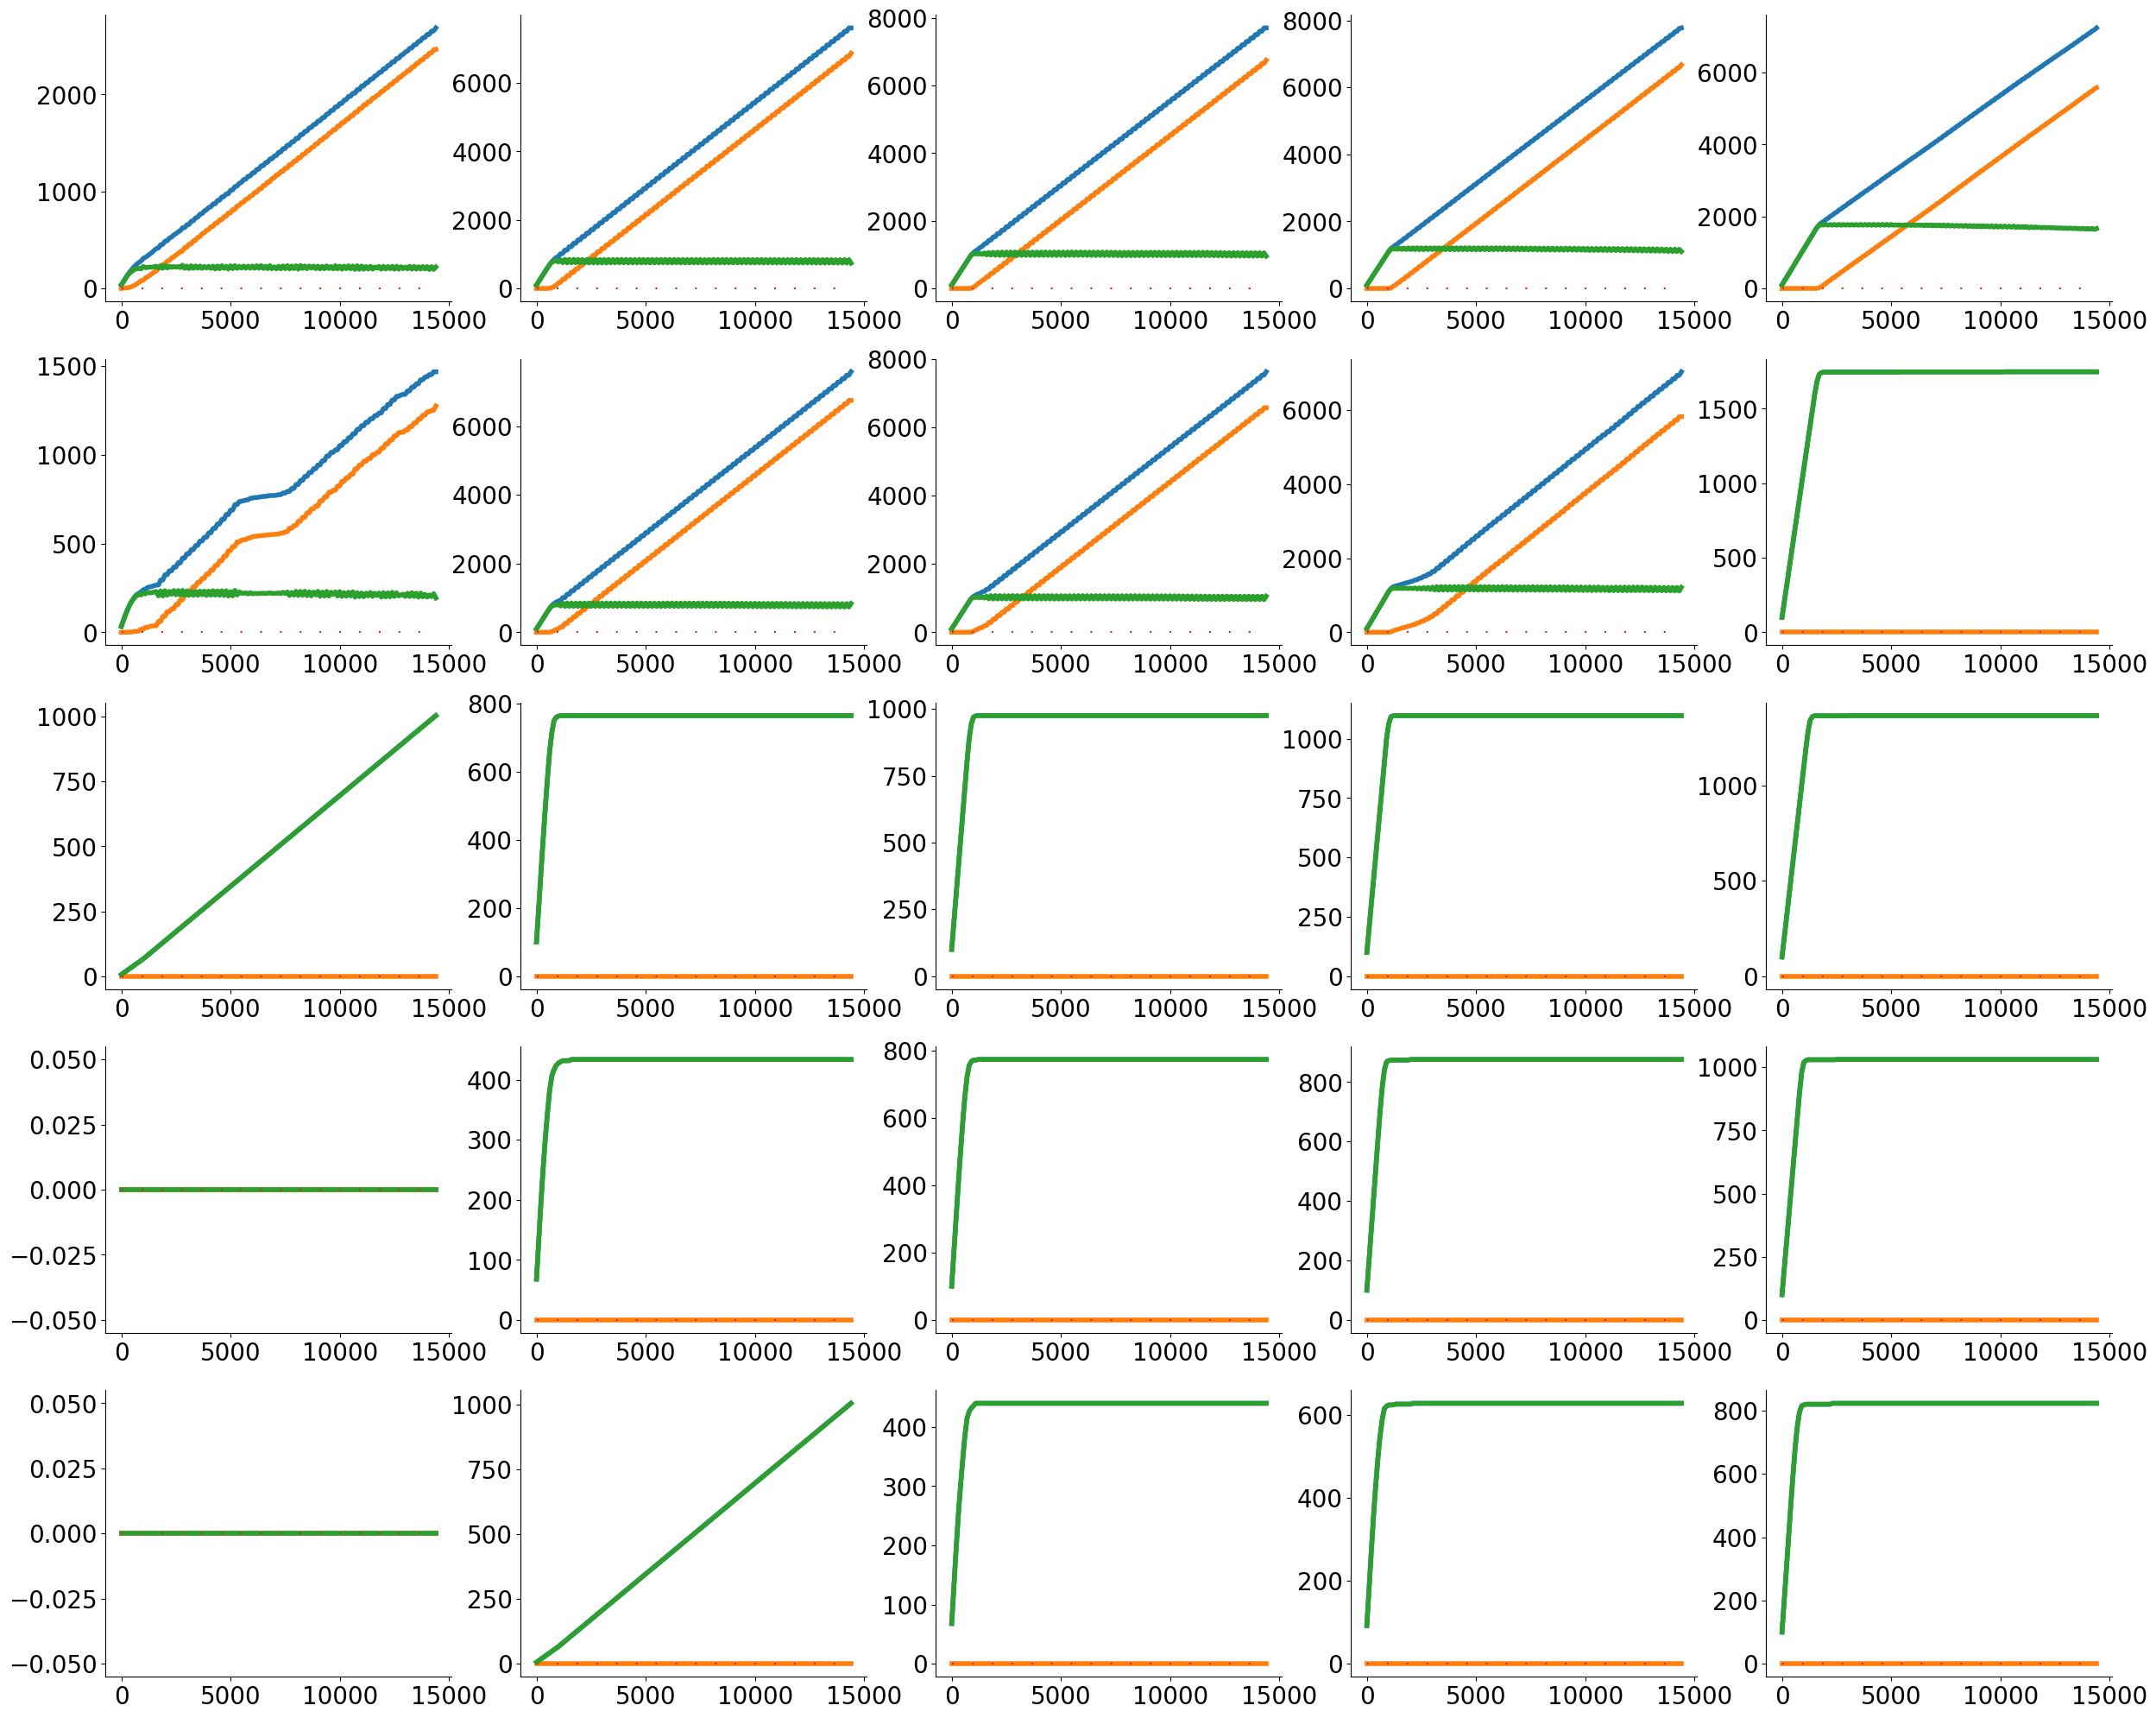

In [34]:
%matplotlib inline
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
reload(connexion_generation.bounded_adsp)
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
reload(connexion_generation.utility)

GROWTH_PARAMETER_ARRAY = [0.001, 0.01, 0.1, 0.3, 0.5]
TARGET_RATE_ARRAY = [0.1, 0.5, 0.7, 0.8, 0.95]


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, 0, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)

# The parameters you want to see the influence
fig, ax = plt.subplots(len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), figsize=(30, 25))


k = 0
for growth_parameter in GROWTH_PARAMETER_ARRAY:
    j = 0
    for target_rate in TARGET_RATE_ARRAY:
        # Initialisation
        W_ee_adsp = W_ee.copy()
        u_train_adsp1 = inputs1.copy()
        state_e = last_state_e
        Win_adsp = Win_e

        step = 0

        total_add = 0
        total_prun = 0
        add = []
        prun = []

        state_history_e = []
        
        for i in range(INTERVAL_CONSTANT * 5):
            state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
            state_history_e.append(state_e)
        u_train_adsp1 = u_train_adsp1[:, INTERVAL_CONSTANT * 5:]
        train_length = len(u_train_adsp1[1, :])

        while train_length > 5000:
            # For excitatory neurons (We and Wie)
            delta_z = compute_synaptic_change(state_history_e[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
            W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z, VALUE)

            # For inhibitory neurons (Wi)
            # delta_z_i = compute_synaptic_change(state_history_i[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
            # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = bounded_adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

            for i in range(INTERVAL_CONSTANT):
                state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
                state_history_e.append(state_e)
            u_train_adsp1 = u_train_adsp1[:, INTERVAL_CONSTANT:]
            train_length = len(u_train_adsp1[1, :])

            total_add += nb_new_add_e  # + nb_new_add_i
            total_prun += nb_new_prun_e # + nb_new_prun_i
            add.append(total_add)
            prun.append(total_prun)

            step += 1
            

        add = np.array(add)
        prun = np.array(prun)
        ax[k][j].plot(np.arange(step) * INTERVAL_CONSTANT, add, linewidth=4, label="total number of added connexion")
        ax[k][j].plot(np.arange(step) * INTERVAL_CONSTANT, prun, linewidth=4, label="total number of prunned connexion")
        ax[k][j].plot(np.arange(step) * INTERVAL_CONSTANT, add - prun, linewidth=4, label="difference")
        ax[k][j].plot(np.arange(step) * INTERVAL_CONSTANT, [0] * step, linestyle=(0, (1, 10)))
        # ax[k][j].set_title(f'\u03B2 :{growth_parameter}     \u03C1 :{target_rate}', fontsize= 20, fontweight= 'bold')
        ax[k][j].tick_params(axis='both', labelsize=20)
        ax[k][j].spines['top'].set_visible(False)
        ax[k][j].spines['right'].set_visible(False)
        j += 1
    k += 1


### for spectral radius

In [36]:
import numpy as np
from joblib import Parallel, delayed
import scipy.sparse as sparse

GROWTH_PARAMETER_ARRAY = [0.001, 0.01, 0.1, 0.3, 0.5]
TARGET_RATE_ARRAY = [0.1, 0.5, 0.7, 0.8, 0.95]
spr = np.zeros((len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), 10))

def run_simulation(growth_parameter, target_rate, l):
    # Initialisation EE
    Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity, spectral_radius)
    bias_e = bias_e*bias_scaling
    Win_e = Win_e*input_scaling

    # last_state
    last_state_e = np.random.uniform(0, 1, n_e)
    last_state_i = np.random.uniform(0, 1, n_i)
    
    # Initialisation
    W_ee_adsp = W_ee.copy()
    u_train_adsp1 = inputs1.copy()
    state_e = last_state_e
    Win_adsp = Win_e

    step = 0

    state_history_e = []

    for i in range(INTERVAL_CONSTANT * 5):
        state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
        state_history_e.append(state_e)
    u_train_adsp1 = u_train_adsp1[:, INTERVAL_CONSTANT * 5:]
    train_length = len(u_train_adsp1[1, :])

    while train_length > 5000:
        # For excitatory neurons (We and Wie)
        delta_z = compute_synaptic_change(state_history_e[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
        W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z, VALUE)

        for i in range(INTERVAL_CONSTANT):
            state_e = update_reservoir(W_ee_adsp, Win_adsp, u_train_adsp1[:,i], state_e, leaky_rate, bias_e, activation_function)
            state_history_e.append(state_e)
        u_train_adsp1 = u_train_adsp1[:, INTERVAL_CONSTANT:]
        train_length = len(u_train_adsp1[1, :])

        step += 1

    eigen = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr  = max(abs(eigen))

    return sr

results = Parallel(n_jobs=-1, verbose=True)(delayed(run_simulation)(growth_parameter, target_rate, l) 
                              for growth_parameter in GROWTH_PARAMETER_ARRAY 
                              for target_rate in TARGET_RATE_ARRAY 
                              for l in range(10))

# Reshape the results
spr1 = np.array(results).reshape(len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), 10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 18.6min finished


## Simulation from blank matrice

Excitatory neuron evolution is given by : 

$ r_E^{t+1} = W_{EE}r_E^{t} - W_{IE}r_I^{t} + W_{in}u^{t} + bias_E $

Inhibitory neurons evolution is given by : 

$ r_I^{t+1} = W_{EI}r_E^{t} + bias_I $


In [ ]:
from reservoir.reservoir import init_matrices

# Parameters
n_e = 100 # number of neurons for excitatory pool
n_i = 0 # number of neurons for inhibitory pool
SEED = 65718 # previous 3789
leaky_rate = 1

spectral_radius = 1
input_connectivity =  1
connectivity_e = 0.1 # from the article
connectivity = 0 # from the article

# HYPERPARAMETERS
bias_scaling = 1
input_scaling = 0.1


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity_e, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# Initialisation EI
_, W_ei, _ =  init_matrices((n_i, n_e), 0, connectivity, 1, seed=SEED)

# Initialisation IE
_, W_ie, _ =  init_matrices((n_e, n_i), 0, connectivity, 1, seed=SEED)

# Initialisation II
_, _, bias_i =  init_matrices(n_i, 0, connectivity, 1, seed=SEED)
bias_i = bias_i*bias_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)
last_state_i = np.random.uniform(0, 1, n_i)

In [ ]:
show_ei_matrix(W_ee, W_ei, W_ie, palette="cividis")

In [ ]:
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
reload(connexion_generation.bounded_adsp)
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
reload(connexion_generation.utility)

# Parameters
# The parameters you want to see the influence
growth_parameter = 0.01
target_rate=0.8

INTERVAL_CONSTANT = 50
VALUE = 0.05

# Initialisation
W_ee_adsp = W_ee.copy()
u_train1 = inputs1[:n_e].copy()
state_e = last_state_e
Win_e_adsp = Win_e

step=0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history_e = []
delta_z_e_history = []

for i in range(INTERVAL_CONSTANT*5):
    state_e = update_reservoir(W_ee_adsp, Win_e_adsp, u_train1[:, i], state_e, leaky_rate, bias_e, activation_function)
    state_history_e.append(state_e)
u_train1 = u_train1[:, INTERVAL_CONSTANT * 5:]

In [ ]:
train_length = len(u_train1[1, :])

while train_length > 10000:

    incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))

     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_e[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INTERVAL_CONSTANT):
        state_e = update_reservoir(W_ee_adsp, Win_e_adsp, u_train1[:, i], state_e, leaky_rate, bias_e, activation_function)
        state_history_e.append(state_e)
    u_train1 = u_train1[:, INTERVAL_CONSTANT:]
    train_length = len(u_train1[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

In [ ]:
# NEURON ACTIVITY PLOT 
plt.figure(figsize=(24,5))
random_neurons_indices =  np.sort(np.random.randint(n_e, size=4)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 9)
colors = color_palette("cividis")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 2000
WATCH_TO = 2500
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    plt.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    plt.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
plt.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target rate")
plt.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
plt.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


### Analysis

In [ ]:
from math import copysign
from analysis.metrics import pearson 
from matplotlib.colors import Normalize

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=4)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 9)
colors = color_palette("cividis")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 4000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target rate")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2, rowspan=2)
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, add, label="total number of added connexion", color='red')
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, prun, label="total number of prunned connexion", color='blue')
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, add-prun, label="difference", color='green')
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp.todense(), cmap=color_palette("cividis", as_cmap=True), ax = ax2)
ax2.text(27, -1, 'Final connectivity',fontsize=20)

#ax3 = plt.subplot2grid((4, 3), (3, 0))
#ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
#        transform=ax3.transAxes)
#ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
#        transform=ax3.transAxes)
#ax3.axis('off')

#ax4 = plt.subplot2grid((4, 3), (3, 1))
#ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
#        transform=ax4.transAxes)
#ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
#        transform=ax4.transAxes)
#ax4.axis('off')

plt.show()

In [ ]:
heatmap(W_ee_adsp.todense(), cmap=color_palette("Greys", as_cmap=True))

### Animations

In [ ]:
import analysis.topology
from importlib import reload
reload(analysis.topology)

from graph_tool.all import graph_draw
from analysis.topology import create_network, animate_network

activity = np.array(state_history_e)[0:100]
g = create_network(W_ee_adsp)
animate_network(g, activity)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(4,1))
activity = np.array(state_history_e)[0:20*INTERVAL_CONSTANT]

# Define a function to draw each frame of the animation
def draw_frame(i):
    ax.clear()
    activities = activity[i]
    a_max = activity.max()
    normalized_activities = activities / a_max  # Normalize between 0 and 1
    colors = plt.cm.viridis(normalized_activities)  # Map to colors using a colormap
    
    x_positions = np.arange(len(activities))
    size = 100  # Modify this to change dot size
    sc = ax.scatter(x_positions, np.zeros_like(activities), c=colors, s=size) 
    ax.set_xlim(-1, len(activities))  # Set x limits to show all nodes
    
    # Add numbers to dots
    for j in range(len(x_positions)):
        ax.text(x_positions[j], 0, str(j+1), ha='center', va='center', color='w', size=5)
        
    ax.axis('off')  # This line turns off the x and y axes
    
# Ensure ani is a global variable
global ani 
ani = animation.FuncAnimation(fig, draw_frame, frames=len(activity), interval=200)
plt.close()
ani.save('animation_states.gif', writer='pillow', fps=30)
HTML(ani.to_jshtml())


In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(4,1))
activity = np.repeat(np.array(delta_z_e_history)[0:20], INTERVAL_CONSTANT, axis=0)
# Define a function to draw each frame of the animation
def draw_frame(i):
    ax.clear()
    activities = activity[i]
    # Shift all values to be positive
    activities_positive_shifted = activities - activities.min()

    # Normalize between 0 and 1
    a_min = activities_positive_shifted.min()
    a_max = activities_positive_shifted.max()
    normalized_activities = (activities_positive_shifted - a_min) / (a_max - a_min)
    colors = plt.cm.inferno(normalized_activities)
    
    x_positions = np.arange(len(activities))
    size = 100  # Modify this to change dot size
    sc = ax.scatter(x_positions, np.zeros_like(activities), c=colors, s=size, marker="s") 
    ax.set_xlim(-1, len(activities))  # Set y limits to show all nodes
    
    # Add numbers to dots
    for j in range(len(x_positions)):
        ax.text(x_positions[j], 0, str(j+1), ha='center', va='center', color='w', size=5)
        
    ax.axis('off')  # This line turns off the x and y axes
    
# Ensure ani is a global variable
global ani 
ani = animation.FuncAnimation(fig, draw_frame, frames=len(activity), interval=200)
plt.close()
ani.save('animation_deltas.gif', writer='pillow', fps=30)
HTML(ani.to_jshtml())

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(4,1))
delta_z = np.array(delta_z_e_history)[0:20]

# Define your conditions and corresponding choices
conditions = [
    delta_z >= 1, 
    delta_z <= -1, 
    np.logical_and(delta_z > -1, delta_z < 1)  # between -1 and 1
]
choices = [1, -1, 0]

# Create the new array using np.select
new_array = np.select(conditions, choices)

activity = np.repeat(new_array, INTERVAL_CONSTANT, axis=0)

# Define a function to draw each frame of the animation
def draw_frame(i):
    ax.clear()
    activities = activity[i]
    y_positions = np.arange(len(activities))
    size = 100  # Modify this to change dot size
    
    color_list = ['red' if a == 1 else 'blue' if a == -1 else 'black' for a in activities]
    text_list = ['+1' if a == 1 else '-1' if a == -1 else '0' for a in activities]

    x_positions = np.arange(len(activities))
    size = 100  # Modify this to change dot size
    sc = ax.scatter(x_positions, np.zeros_like(activities), c="white", s=size) 
    ax.set_xlim(-1, len(activities))  # Set y limits to show all nodes
       
    # Add numbers to dots
    for j in range(len(y_positions)):
        ax.text(x_positions[j], 0, text_list[j], ha='center', va='center', color=color_list[j], size=10)

    ax.axis('off')  # This line turns off the x and y axes
    
# Ensure ani is a global variable
global ani 
ani = animation.FuncAnimation(fig, draw_frame, frames=len(activity), interval=200)
plt.close()
ani.save('animation_add_prune.gif', writer='pillow', fps=30)
HTML(ani.to_jshtml())

## Hebbian learning exemple

### Visualisation

In [ ]:
from scipy.stats import poisson

mu = 100
timesteps = 10000

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs_visu = (U - U.min()) / (U.max() - U.min())/4

inputs_visu[50:60,4000:7000] = inputs_visu[50:60,4000:7000]+1
plt.figure(figsize=(24,10))

ax = plt.subplots(3, 1,figsize=(24,12))
ax[1][0].plot(range(10000), inputs_visu[53,0:10000], label="53")
ax[1][0].legend(fontsize=26)
ax[1][1].plot(range(10000), inputs_visu[55,0:10000], label="55", color = "orange")
ax[1][1].legend(fontsize=26)
ax[1][2].plot(range(10000), inputs_visu[98,0:10000], label="98", color = "green")
ax[1][2].legend(fontsize=26)
ax[1][0].spines['top'].set_visible(False)
ax[1][0].spines['right'].set_visible(False)
ax[1][1].spines['top'].set_visible(False)
ax[1][1].spines['right'].set_visible(False)
ax[1][2].spines['top'].set_visible(False)
ax[1][2].spines['right'].set_visible(False)
ax[1][0].tick_params(axis='both', labelsize=26)
ax[1][1].tick_params(axis='both', labelsize=26)
ax[1][2].tick_params(axis='both', labelsize=26)

plt.ylim(0, 1)

plt.show()

### Scenario

In [ ]:
from scipy.stats import poisson

mu = 100
timesteps = 100000

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs2 = (U - U.min()) / (U.max() - U.min())

inputs2[50:60,:] = inputs2[50:60,:]*10
plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs2[43,16000:17000], color="gold")
plt.axis("off")
plt.show()

In [ ]:
u_train2 = inputs2.copy()

W_ee_adsp_hebbian = W_ee_adsp.copy()
Win_e_adsp_hebbian = Win_e

step=0
state_hebbian = state_e

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

state_history_hebbian = []
delta_z_e_history = []
train_length = len(u_train2[1, :])

In [ ]:
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("cividis", as_cmap=True))

In [ ]:
while train_length > 500:
     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_hebbian[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp_hebbian, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp_hebbian, state_hebbian, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INTERVAL_CONSTANT):
        state_hebbian = update_reservoir(W_ee_adsp_hebbian, Win_e_adsp_hebbian, u_train2[:, i], state_hebbian, leaky_rate, bias_e, activation_function)
        state_history_hebbian.append(state_hebbian)
    u_train2 = u_train2[:, INTERVAL_CONSTANT:]
    train_length = len(u_train2[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

In [ ]:
from math import copysign
from analysis.metrics import pearson 

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=8)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 7000
WATCH_TO = 8000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, add-prun, label="difference")
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,0, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.axis('off')

ax4 = plt.subplot2grid((4, 3), (3, 1))
ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.axis('off')

plt.show()

In [ ]:
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("cividis", as_cmap=True))

In [ ]:
from scipy.stats import poisson

mu = 100
timesteps = 100000

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs3 = (U - U.min()) / (U.max() - U.min())

plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs3[52,16000:17000])
plt.show()

In [ ]:
u_train3 = inputs3.copy()

step=0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

state_history_e = []
delta_z_e_history = []
train_length = len(u_train3[1, :])

while train_length > 500:
     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_e[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp_hebbian, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp_hebbian, state_e, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INTERVAL_CONSTANT):
        state_e = update_reservoir(W_ee_adsp_hebbian, Win_e_adsp_hebbian, u_train3[:, i], state_e, leaky_rate, bias_e, activation_function)
        state_history_e.append(state_e)
    u_train3 = u_train3[:, INTERVAL_CONSTANT:]
    train_length = len(u_train3[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

In [ ]:
from math import copysign
from analysis.metrics import pearson 

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=8)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 7000
WATCH_TO = 8000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, add-prun, label="difference")
ax1.plot(np.arange(step)*INTERVAL_CONSTANT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,0, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.axis('off')

ax4 = plt.subplot2grid((4, 3), (3, 1))
ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.axis('off')

plt.show()

In [ ]:
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("cividis", as_cmap=True))

# Measurement
We create a comparable matrice for measurment

In [ ]:
eigen_adsp = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_adsp = max(abs(eigen_adsp))
sr_adsp

## Richness in reservoir

### Memory capacity

$$  y_{d_i} = \prod_i{P_{d_i}(u(t-i))}$$

#### Without adsp

In [ ]:
import analysis.capacities as CAP
# Helper function to use the capacities data structure coming out of the iterator
# cap2vec collates all capacities with same maximal delay and degree up to given maximal values
def cap2vec(capacities,maxdel=1000,maxdeg=10):
    vec = np.zeros((maxdel,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        if (delay<=maxdel) and (degree<=maxdeg):
            vec[delay-1,degree-1]+=capacities[idx]['score']
    return vec

maxdel = 15
maxdeg = 7

TRYOUT = 10
V = np.zeros((maxdel, maxdeg))
for i in range(TRYOUT):
    print("\nRound :", i)
    # We generate a network randomly with same spectral radius and same connectivity as the ADSP generated one
    connectivity_desired =  W_ee_adsp.count_nonzero() / (W_ee_adsp.shape[0] * W_ee_adsp.shape[1])
    _, W_ee_w, _ =  init_matrices(n_e, input_connectivity, connectivity_desired, spectral_radius)
    eigen_adsp = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_adsp = max(abs(eigen_adsp))
    eigen_w = sparse.linalg.eigs(W_ee_w, k=1, which="LM", maxiter=W_ee_w.shape[0] * 20, tol=0.1, return_eigenvectors=False)
    sr_w = max(abs(eigen_w))
    W_ee_w = W_ee_w*sr_adsp/sr_w

    # Number of time steps: you can use 1e5 for quick-and-dirty, but 1e6 is better
    warmup_steps = 500
    warmups = 2.0*np.random.rand(warmup_steps,1)-1.0

    # Important: capacity theory with Legendre polynomials assumes uniform random inputs in [-1,1]
    steps = 1000000
    inputs = 2.0*np.random.rand(steps,1)-1.0

    for i in range(warmup_steps):
        state_e = update_reservoir(W_ee_w, Win_e, warmups[i], state_e, leaky_rate, bias_e, activation_function)

    capa_history_e = []
    for i in range(steps):
        state_e = update_reservoir(W_ee_w, Win_e, inputs[i], state_e, leaky_rate, bias_e, activation_function)
        capa_history_e.append(state_e)
    capa_history_e = np.array(capa_history_e)
    connectivity_desired
    
    # Measallcapsure capacities on inputs and states after removing a "warmup period"
    # If you require more extensive printed output of individual capacities:
    # set verbose = 1
    Citer=CAP.capacity_iterator(maxdeg=7, maxdel=100)#, verbose = 1)
    totalcap,allcaps,numcaps,nodes = Citer.collect(inputs,capa_history_e)

    print("\nMeasured ",numcaps," capacities above threshold.\nTotal capacity = ",totalcap)

    V = V  + cap2vec(allcaps,maxdel = maxdel, maxdeg = maxdeg)
V = V/TRYOUT
    

In [ ]:
heatmap(W_ee_w.todense(), cmap=color_palette("vlag", as_cmap=True))

In [ ]:
plt.figure(figsize=(2,4))

values = np.sum(V, axis=0)
height = 0
for i, v in enumerate(values):
    plt.bar(0, v, bottom=height, color=plt.cm.tab10(i))
    height = height + v

plt.xticks([0, 1], ('normal', 'adsp'))
plt.show()

In [ ]:

# maxdel = 15
# maxdeg = 10
# V = cap2vec(allcaps,maxdel = maxdel, maxdeg = maxdeg)

delrange = np.arange(1,maxdel+1)
totcap = np.sum(V,axis=1)
plt.figure(figsize=(3,4))
plt.semilogy(delrange,V[:,0],label='Linear')
plt.plot(delrange,V[:,1],label='Qadratic')
plt.plot(delrange,V[:,2],label='Qubic')
plt.plot(delrange,V[:,3],label='4')
plt.plot(delrange,V[:,4],label='5')

plt.xlabel('Maximal delay')
plt.ylabel('Total capacity')

plt.show()



#### With adsp

In [ ]:
import connexion_generation.bounded_adsp
import connexion_generation.utility

import reservoir.reservoir
from reservoir.reservoir import update_reservoir
reload(reservoir.reservoir)

# Parameters
# The parameters you want to see the influence
growth_parameter = 0.1
target_rate=0.7

INTERVAL_CONSTANT = 100
VALUE = 0.05

V_adsp = []

W_ee_adsp_history = []

MAX_NUMBERS_CONNECTIONS = [2, 8, 12, 20]
TRYOUT = 1
MAX_DEG = 6
MAX_DEL = 20
j = 0 
for max_number_connection in MAX_NUMBERS_CONNECTIONS:
    V_adsp.append(np.zeros((maxdel, maxdeg)))
    for i in range(TRYOUT):
        print("\nRound :", i)
        # Initialisation
        W_ee_adsp = W_ee.copy()
        u_train1 = inputs1.copy()
        state_e = last_state_e
        Win_e_adsp = Win_e

        # last_state
        last_state_e = np.random.uniform(0, 1, n_e)
        step=0

        state_history_e = []
        delta_z_e_history = []

        for i in range(INTERVAL_CONSTANT*5):
            state_e = update_reservoir(W_ee_adsp, Win_e_adsp, u_train1[:, i], state_e, leaky_rate, bias_e, activation_function)
            state_history_e.append(state_e)
        u_train1 = u_train1[:, INTERVAL_CONSTANT * 5:]


        train_length = len(u_train1[1, :])
        

        while train_length > 10000:
             # For excitatory neurons (We)
            delta_z_e = compute_synaptic_change(state_history_e[-INTERVAL_CONSTANT:], target_rate, growth_parameter, average="QUEUE")
            W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z_e, VALUE, max_connections = max_number_connection)
            delta_z_e_history.append(delta_z_e)

            for i in range(INTERVAL_CONSTANT):
                state_e = update_reservoir(W_ee_adsp, Win_e_adsp, u_train1[:, i], state_e, leaky_rate, bias_e, activation_function)
                state_history_e.append(state_e)
            u_train1 = u_train1[:, INTERVAL_CONSTANT:]
            train_length = len(u_train1[1, :])

        W_ee_adsp_history.append(W_ee_adsp)
        
        warmup_steps = 500
        warmups = 2.0*np.random.rand(warmup_steps,1)-1.0

        # Important: capacity theory with Legendre polynomials assumes uniform random inputs in [-1,1]
        steps = 1000000
        inputs = 2.0*np.random.rand(steps,1)-1.0

        state_e_adsp = last_state_e
        for i in range(warmup_steps):
            state_e_adsp = update_reservoir(W_ee_adsp, Win_e_adsp, warmups[i], state_e_adsp, leaky_rate, bias_e, activation_function)

        capa_history_e_adsp = []
        for i in range(steps):
            state_e_adsp = update_reservoir(W_ee_adsp, Win_e_adsp, inputs[i], state_e_adsp, leaky_rate, bias_e, activation_function)
            capa_history_e_adsp.append(state_e_adsp)
        capa_history_e_adsp = np.array(capa_history_e_adsp)

        # Measallcapsure capacities on inputs and states after removing a "warmup period"
        # If you require more extensive printed output of individual capacities:
        # set verbose = 1
        Citer=CAP.capacity_iterator(maxdeg=MAX_DEG, maxdel=MAX_DEL)#, verbose = 1)
        totalcap_adsp,allcaps_adsp,numcaps_adsp,nodes = Citer.collect(inputs,capa_history_e_adsp)

        print("\nMeasured ",numcaps_adsp," capacities above threshold.\nTotal capacity = ",totalcap_adsp)
        V_adsp[j] = V_adsp[j]  + cap2vec(allcaps_adsp,maxdel = MAX_DEL, maxdeg = MAX_DEG)
    V_adsp[j] = V_adsp[j]/TRYOUT
    j = j+1

In [ ]:
heatmap(W_ee_adsp_history[-1].todense(), cmap=color_palette("vlag", as_cmap=True))

eigen_w = sparse.linalg.eigs(W_ee_adsp_history[3], k=1, which="LM", maxiter=W_ee_w.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_w = max(abs(eigen_w))
sr_w

In [ ]:
V_adsp_array = np.array(V_adsp)


In [ ]:
plt.figure(figsize=(6,4))

for j, m in enumerate(MAX_NUMBERS_CONNECTIONS):
    values_adsp = np.sum(V_adsp_array[:, :, :6][j], axis=0)
    values_adsp = np.append(values_adsp, 100-np.sum(values_adsp)) 
    height = 0
    for i, v in enumerate(values_adsp):
        plt.bar(j, v, bottom=height, color=plt.cm.tab10(i))
        plt.text(j-0.05, height+v/2-1, str(int(v)))
        height = height + v

plt.xticks(range(len(MAX_NUMBERS_CONNECTIONS)), MAX_NUMBERS_CONNECTIONS)
plt.ylim(0, 100)
plt.show()
maxdel

In [ ]:

delrange = np.arange(1,maxdel+1)
totcap = np.sum(V_adsp,axis=1)
plt.figure(figsize=(3,4))
plt.semilogy(delrange,V_adsp[:,0],llabel='Linear')
plt.plot(delrange,V_adsp[:,1],label='Qadratic')
plt.plot(delrange,V_adsp[:,2],label='Qubic')
plt.plot(delrange,V_adsp[:,3],label='4')
plt.plot(delrange,V_adsp[:,4],label='5')

# legend_elements = [plt.Line2D([0], [0], color='tab:blue', label='linear'),
#                    plt.Line2D([0], [0], color='tab:orange', label='Qadratic'),
#                    plt.Line2D([0], [0], color='tab:green', label='Qubic'),
#                    plt.Line2D([0], [0], color='tab:red', label='4'),
#                    plt.Line2D([0], [0], color='tab:purple', label='5'),
#                    plt.Line2D([0], [0], color='tab:brown', label='6'),
#                    plt.Line2D([0], [0], color='tab:pink', label='7'),
#                    plt.Line2D([0], [0], color='tab:gray', label='8 and above')]


plt.xlabel('Maximal delay')
# plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.1,1.6))
plt.show()

#### Comparaison

In [ ]:
print(values)
print(values_adsp)

In [ ]:
plt.figure(figsize=(2,4))

values = np.sum(V, axis=0)
values = np.append(values, 100-np.sum(values)) 
values_adsp = np.sum(V_adsp, axis=0)
values_adsp = np.append(values_adsp, 100-np.sum(values_adsp)) 

height = 0
for i, v in enumerate(values):
    plt.bar(0, v, bottom=height, color=plt.cm.tab10(i))
    height = height + v

height = 0
for i, v in enumerate(values_adsp):
    plt.bar(1, v, bottom=height, color=plt.cm.tab10(i))
    height = height + v

plt.xticks([0, 1], ('normal', 'adsp'))
plt.ylim(0, 100)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(4,3))

plt.plot(range(12),V[0:12,0],label='random', color="blue", marker="X")
plt.plot(range(12),V_adsp[0:12,0],label='ADSP', marker=".")
plt.grid()
plt.xlabel('Delay')
plt.ylabel('Capacity')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend()


### Spectral radius

In [ ]:
eigen_adsp = sparse.linalg.eigs(W_ee_adsp, k=1, which="LM", maxiter=W_ee_adsp.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_adsp = max(abs(eigen_adsp))
sr_adsp

In [ ]:
eigen_w = sparse.linalg.eigs(W_ee_w, k=1, which="LM", maxiter=W_ee_w.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr_w = max(abs(eigen_w))
sr_w

### Uncoupled dynamics

number of the principal components (i.e. orthogonal diretions of variability) that are able to explain the most of the variance in the reservoir state space

https://arxiv.org/pdf/1903.05174.pdf

$$ UD =  \underset{d}{\arg\min} \{ \sum\limits_{k=1}^d R_k|\sum\limits_{k=1}^dR_k ≥ A\}$$

with  $R_k = \frac{σ_k}{\sum\limits_{j=1}^{N_R}σ_j} $

In [ ]:
from analysis.metrics import uncoupled_dynamics
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 20000
warmup_steps = 500
steps = timesteps + warmup_steps
tau = 17
# X = mackey_glass(steps, tau=tau)
X = 2.0*np.random.rand(steps,1)-1.0
# rescale between -1 and 1
inputs = 2 * (X - X.min()) / (X.max() - X.min()) - 1

## Calculous for simple RNN
state_e = last_state_e
state_i = last_state_i
history_e = []
for i in range(steps):
    state_e, state_i = update_ei_reservoir(W_ee_w, W_ie, W_ei, Win_e, inputs[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    history_e.append(state_e)
history_e = np.array(history_e)[warmup_steps:]
UD = uncoupled_dynamics(history_e, temp = 5000, A= 0.9)
print(UD)

## Calculous for adsp RNN
state_e_adsp = last_state_e
state_i_adsp = last_state_i
history_e_adsp = []
for i in range(steps):
    state_e_adsp, state_i_adsp = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, inputs[i], state_e_adsp, state_i_adsp, leaky_rate, bias_e, bias_i, activation_function)
    history_e_adsp.append(state_e_adsp)
history_e_adsp = np.array(history_e_adsp)[warmup_steps:]
UD_adsp = uncoupled_dynamics(history_e_adsp, temp = 5000, A= 0.9)

print(UD_adsp)


### Pearson coeffcients

$$ corr(x_i(t), x_k(t+1))) = \frac{\sum\limits_{t=1}^{T-1}{(x_i(t)-\bar{x_i})(x_k(t)-\bar{x_k})}} {\sqrt{\sum\limits_{t=1}^{T-1}{(x_i(t)-\bar{x_i})^2}}\sqrt{\sum\limits_{t=1}^{T-1}{(x_k(t)-\bar{x_k})^2}}} $$

In [ ]:
from analysis.metrics import pearson_matrix

plt.figure(figsize=(12,4))

ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
Pearson = pearson_matrix(history_e[:20000,])
heatmap(Pearson)

ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
Pearson = pearson_matrix(history_e_adsp[:20000,])
heatmap(Pearson)

The mean Pearson coefficient is given by

$$ \bar{Corr} = \frac{1}{N^2} \sum\limits_{i=1}^{N}\sum\limits_{k=1}^{N}corr(x_i(t), x_k(t+1)) $$

In [ ]:
print(np.mean(pearson_matrix(history_e[:20000,])))
print(np.mean(pearson_matrix(history_e_adsp[:20000,])))

### Average State Entropy

efficient estimator of Renyi’s quadratic entropy 

https://arxiv.org/pdf/1903.05174.pdf

https://www.researchgate.net/publication/2818138_Information-Theoretic_Learning_Using_Renyi's_Quadratic_Entropy4

*"H(t) which is the sum of all pairs of interactions can be regarded as an overall potential energy of the data set. We will call this potential energy an information potential (IP). So **maximizing entropy** becomes equivalent to **minimizing information potential**"*


https://ia800704.us.archive.org/view_archive.php?archive=/24/items/wikipedia-scholarly-sources-corpus/10.1162.zip&file=10.1162%252Fneco.2007.19.1.111.pdf



$$H(t) = −log( \frac{1}{N_R^2}\sum\limits_{j=1}^{N_R}(\sum\limits_{i=1}^{N_R}G _{0.3}(x_j(t) - x_i (t))))$$

In [ ]:
from analysis.metrics import renyi_entropy

In [ ]:
print(np.mean(renyi_entropy(history_e[:20000,])))
print("adsp", np.mean(renyi_entropy(history_e_adsp[:20000,])))

## Topology

In [ ]:
%matplotlib inline
%matplotlib --list

In [ ]:
from analysis.topology import create_network, draw_network

g = create_network(W_ee_w, Win_e)
draw_network(g, n_e)

In [ ]:
g = create_network(W_ee_adsp)
draw_network(g, n_e)

### Connexion number histogram

In [ ]:
# Incoming connexions histogram
def plot_incoming_co_histogram(W_ee, W_ei, W_ie, ax=None):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=1)
    connections_ie = np.sum(np.where(W_ie <= 0, W_ie, 1), axis=1)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

# Incoming connexions histogram
def plot_outcoming_co_histogram(W_ee, W_ei, W_ie, ax=ax1):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=0)
    connections_ie = np.sum(np.where(W_ei <= 0, W_ei, 1), axis=0)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

fig = plt.figure(figsize=(16,8))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
plot_incoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax1)
ax1.set_ylabel("connexions before adsp")
ax1.set_title("Incoming connexions")


ax2 = fig.add_subplot(gs[0, 1])
plot_outcoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax2)
ax2.set_title("Outcoming connexions")

ax3 = fig.add_subplot(gs[1, 0])
plot_incoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax3)
ax3.set_ylabel("connexions after adsp")

ax4 = fig.add_subplot(gs[1, 1])
plot_outcoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax4)


In [ ]:
from graph_tool.all import GraphView, corr_hist
g = create_network(W_ee_w)

gv= GraphView(g, directed=False)
h = corr_hist(g, "out", "out")

plt.clf()
plt.xlabel("Source out-degree")

plt.ylabel("Target out-degree")

plt.imshow(h[0].T, interpolation="nearest", origin="lower")

plt.colorbar()


### Centrality
https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust

#### Katz centrality

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/Katz_centrality
# https://graph-tool.skewed.de/static/doc/centrality.html#graph_tool.centrality.katz
from graph_tool.all import katz, graph_draw, prop_to_size, arf_layout
import matplotlib

g = create_network(W_ee_w)

x = katz(g, weight=g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=x,
              vertex_size=prop_to_size(x, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=x)

#### EigenTrust

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/EigenTrust
# https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust
from graph_tool.all import eigentrust, graph_draw, prop_to_size
import matplotlib

g = create_network(W_ee_w)

t = eigentrust(g, g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=t,
              vertex_size=prop_to_size(t, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=t)

### Shortest path

In [ ]:
from graph_tool.all import count_shortest_paths

g = create_network(W_ee_w)
n_paths = count_shortest_paths(g, 12, 35)

print(n_paths)

### Correlation
https://graph-tool.skewed.de/static/doc/correlations.html#graph_tool.correlations.corr_hist

In [ ]:
from graph_tool.all import GraphView, assortativity, scalar_assortativity
g = create_network(W_ee_w)

# Return the assortativity coefficient, and its variance.
gv= GraphView(g, directed=False)
print(assortativity(gv, "out"))
print(scalar_assortativity(gv, "out"))